In [13]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, roc_curve, auc
from collections import defaultdict

import sys
sys.path.append('../')
from model.baselines import CreateBaselines
from src.funcs import find_optimal_cutoff

data_dir = '../data/seed_training/'
output_dir = '../output/'

# Load data

In [2]:
test = pd.read_hdf('../data/data.h5', 'test')
solubility = pd.read_hdf('../data/data.h5', 'solubility')
sodope = pd.read_hdf('../data/data.h5', 'sodope')

sodope.drop(
        columns=[
            'is_expression_successful',
            'A', 'C', 'D', 'E', 'F', 
            'G', 'H', 'I', 'K', 'L', 
            'M', 'N', 'P', 'Q', 'R', 
            'S', 'T', 'V', 'W', 'Y'
        ], 
        inplace=True
    )
solubility.drop(
        columns=[
            'A', 'C', 'D', 'E', 'F', 
            'G', 'H', 'I', 'K', 'L', 
            'M', 'N', 'P', 'Q', 'R', 
            'S', 'T', 'V', 'W', 'Y'
        ],
        inplace=True
    )
test = test.merge(solubility, left_on='protein', right_on='antibody', how='left').merge(sodope, on=['protein', 'key', 'tfkey', 'tax_kingdom', 'tax_class', 'tax_phylum'])

test.drop(
        columns=[
            'Unnamed: 0', 'protein_length_x', 'protein_length_y',
            'nuc_R', 'nuc_Y', 'nuc_W','nuc_S', 'nuc_M', 'nuc_K', 'nuc_H', 'nuc_B', 'nuc_V', 'nuc_D', 'nuc_N',
            'protein_mw', 'protein_pI', 'cluster'
        ], inplace=True)

test.rename(columns={'unit_' + str(i+1): i for i in range(1900)}, inplace=True)

# Calculate correlations

In [3]:
rerun = False
if rerun:
    valid = pd.read_hdf('../data/data.h5', 'valid')
    test = pd.read_hdf('../data/data.h5', 'test')
    comb = pd.concat([valid, test], axis=0, sort=False)

    solubility = pd.read_hdf('../data/data.h5', 'solubility')
    solubility.drop(
        columns=[
            'A', 'C', 'D', 'E', 'F', 
            'G', 'H', 'I', 'K', 'L', 
            'M', 'N', 'P', 'Q', 'R', 
            'S', 'T', 'V', 'W', 'Y'
        ],
        inplace=True
    )

    sodope = pd.read_hdf('../data/data.h5', 'sodope')
    sodope.drop(
        columns=[
            'is_expression_successful',
            'A', 'C', 'D', 'E', 'F', 
            'G', 'H', 'I', 'K', 'L', 
            'M', 'N', 'P', 'Q', 'R', 
            'S', 'T', 'V', 'W', 'Y'
        ], 
        inplace=True
    )

    comb = comb.merge(solubility, left_on='protein', right_on='antibody', how='left')
    comb = comb.merge(sodope, on=['protein', 'key', 'tfkey', 'tax_kingdom', 'tax_class', 'tax_phylum'])
    #comb.drop(columns=['antibody'], inplace=True)

    enz_data = pd.read_excel('data/data_combined_cleaned_hhm.xlsx', sheet_name='combined_fixed')
    enz_data.rename(columns={'Family': 'Enzyme_Family', 'Category3': 'Enzyme'}, inplace=True)
    enz_data['Enzyme_Family'].fillna('Other', inplace=True)
    comb = comb.merge(enz_data.drop(columns='is_expression_successful'), on=['protein', 'key'])


    y = 'is_expression_successful'
    unit_cols = [x for x in comb.columns if x.startswith('unit')]
    solubility_cols = solubility.columns.tolist()
    sodope_cols = sodope.columns.tolist()

    obj_cols = ['tax_kingdom', 'Enzyme', 'Enzyme_Family', 'tax_class', 'tax_phylum']#, 'tax_class', 'tax_phylum']
    for col in obj_cols:
        comb = pd.concat([comb, pd.get_dummies(comb[col], prefix=col)], axis=1)
        comb.drop(columns=col, inplace=True)
        
        
    # Porter 4.0 secondary structures
    ss = defaultdict(dict)
    seq = ''

    with open('data/expr.porter', 'r') as f:
        for line in f.readlines():
            if line.startswith('>'):
                protein_id = line.strip().replace('>', '')

                if len(seq) > 0:
                    seq_len = len(seq)
                    for letter, key in zip(['C', 'E', 'H'], ['Coil_pct', 'Strand_pct', 'Helix_pct']):
                        ss[protein_id][key] = (seq.count(letter) / seq_len) * 100

                seq = ''
            else:
                seq += line.strip()

    ss = pd.DataFrame.from_dict(ss, orient='index')
    
    comb = comb.merge(ss, left_on='key', right_index=True)

    comb.drop(
        columns=[
            'Unnamed: 0', 'protein_length_x', 'protein_length_y',
            'nuc_R', 'nuc_Y', 'nuc_W','nuc_S', 'nuc_M', 'nuc_K', 'nuc_H', 'nuc_B', 'nuc_V', 'nuc_D', 'nuc_N',
            'protein_mw', 'protein_pI', 'cluster'
        ] + comb.columns[(~comb.columns.isin(valid_codons)) & (comb.columns.str.startswith('codon'))].tolist() + comb.columns[(comb == 0).all()].tolist() ,
        inplace=True
    )

    corr_columns = comb.select_dtypes(exclude=['object', 'category']).columns.tolist()
    corrs = corr_pval(comb, col1=corr_columns, col2=corr_columns)
    corrs.to_hdf('../data/corrs.h5', 'corrs')
else:
    corrs = pd.read_hdf('../data/corrs.h5', 'corrs')
    
    unit_cols = ['unit_' + str(i) for i in range(1, 1901)]
    solubility_cols = [
        'antibody', 'scaled_sol', 'K-R', 'D-E', 'Number of amino acids', 'K+R',
        'D+E', 'K+R-D-E', 'K+R+D+N', 'F+W+Y', 'pI', 'kyte doolittle',
        'absolute charge', 'Fold propensity', 'disorder', 'entropy',
        'beta proprensity'
    ]

    sodope_cols = [
        'construct_id', 'protein', 'key', 'tfkey', 'tax_kingdom',
        'tax_class', 'tax_phylum', 'protein_length', 'isoelectric_point',
        'molecular_weight', 'gravy', 'SWI', 'X3', 'Prob.(Solubility)'
    ]

# Parse pickled models

In [4]:
model2name = {'RF': 'baseline_rf', 'SVM': 'baseline_linear', 'LR': 'baseline_log'}

y_true = test['is_expression_successful']

# model_file: iter: params
params = defaultdict(dict)
ann_res = defaultdict(list)
for model_file in sorted(os.listdir(data_dir)):
    train_aucs, valid_aucs, test_aucs, test_mccs = [], [], [], []
    
    n1 = model_file.split('.')[0][-3:]
    n2 = n1[-2:]
    if 'Enzyme' in model_file or 'Top' in model_file:
        continue
    elif 'ANN' in model_file:
        model = pickle.load(open(data_dir + model_file, 'rb'))
        anndf = pd.DataFrame.from_dict(model['params'], orient='index')
        anndf.index.name = 'Parameter'
        parameters = anndf.index.tolist()
        anndf.loc['Valid AUC', :] = np.nan
        for i in range(10):
            anndf.loc[parameters, i] = anndf.loc[parameters, 0]
            anndf.loc['Valid AUC', i] = model[i]['valid_auc']
        
        model_input = "".join(model_file.split('_')[:2])
        
        ann_res[model_input].append(anndf)


    else:
        model = pickle.load(open(data_dir + model_file, 'rb'))
        
        for k, v in model.items():
            if k == 'input_cols' or k == 'params': continue
            
            train_aucs.append(v['train_auc'])
            valid_aucs.append(v['valid_auc'])
            
            if n2 in model2name:
                predictor = getattr(v['model'], model2name[n2])
            elif n1 in model2name:
                predictor = getattr(v['model'], model2name[n1])
            else: 
                continue
            

            try:
                X_test = test[v['model'].X_train.columns]
            except:
                continue
            y_pred = predictor.predict_proba(X_test)[:, 1]

            fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
            test_aucs.append(auc(fpr, tpr))

            test_mccs.append(matthews_corrcoef(y_true, predictor.predict(X_test)))
            
            # save params
            params[model_file][k] = predictor.best_params_


        print("model_file:", model_file)
        print("Train AUC: {:.2f} (+/-) {:.2f}".format(np.mean(train_aucs), np.std(train_aucs)))
        print("Valid AUC: {:.2f} (+/-) {:.2f}".format(np.mean(valid_aucs), np.std(valid_aucs)))    
        print("Test AUC: {:.2f} (+/-) {:.2f}".format(np.mean(test_aucs), np.std(test_aucs)))    
        print("Test MCC: {:.2f} (+/-) {:.2f}".format(np.mean(test_mccs), np.std(test_mccs)))

model_file: AAFreqLR.pkl
Train AUC: 0.62 (+/-) 0.00
Valid AUC: 0.57 (+/-) 0.00
Test AUC: 0.60 (+/-) 0.00
Test MCC: 0.12 (+/-) 0.00
model_file: AAFreqRF.pkl
Train AUC: 1.00 (+/-) 0.00
Valid AUC: 0.57 (+/-) 0.01
Test AUC: 0.59 (+/-) 0.01
Test MCC: 0.14 (+/-) 0.02
model_file: AAFreqSVM.pkl
Train AUC: 0.60 (+/-) 0.02
Valid AUC: 0.55 (+/-) 0.02
Test AUC: 0.58 (+/-) 0.02
Test MCC: 0.04 (+/-) 0.05


/Users/hanmar/Documents/repos/thesis_paper/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/hanmar/Documents/repos/thesis_paper/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


model_file: BorutaUniRepRF.pkl
Train AUC: 1.00 (+/-) 0.00
Valid AUC: 0.66 (+/-) 0.01
Test AUC: 0.64 (+/-) 0.01
Test MCC: 0.20 (+/-) 0.04
model_file: SolubilityRF.pkl
Train AUC: 1.00 (+/-) 0.00
Valid AUC: 0.54 (+/-) 0.00
Test AUC: nan (+/-) nan
Test MCC: nan (+/-) nan


/Users/hanmar/Documents/repos/thesis_paper/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hanmar/Documents/repos/thesis_paper/env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hanmar/Documents/repos/thesis_paper/env/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hanmar/Documents/repos/thesis_paper/env/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hanmar/Documents/repos/thesis_paper/env/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


model_file: UniRepLR.pkl
Train AUC: 0.81 (+/-) 0.00
Valid AUC: 0.60 (+/-) 0.00
Test AUC: 0.64 (+/-) 0.00
Test MCC: 0.18 (+/-) 0.00
model_file: UniRepRF.pkl
Train AUC: 1.00 (+/-) 0.00
Valid AUC: 0.66 (+/-) 0.01
Test AUC: 0.64 (+/-) 0.01
Test MCC: 0.19 (+/-) 0.02
model_file: UniRepSVM.pkl
Train AUC: 0.73 (+/-) 0.04
Valid AUC: 0.59 (+/-) 0.02
Test AUC: 0.62 (+/-) 0.02
Test MCC: 0.14 (+/-) 0.04


Create parameter table

In [5]:
ann_param_dfs = []
for k, v in ann_res.items():
    annres_df = pd.concat(v, axis=0).reset_index()
    
    annres_iters = []
    for col, idx in enumerate(annres_df.loc[annres_df.Parameter == 'Valid AUC', np.arange(0, 10)].idxmax()):
        annres_iters.append(
            annres_df.iloc[i-3:i+1, [0, col+1]].copy()
        )
    annres_iters_df = pd.concat(annres_iters, axis=1)

    annres_iters_df = annres_iters_df.loc[:, ~annres_iters_df.columns.duplicated()].set_index('Parameter')
    annres_iters_df.drop(index='Valid AUC', inplace=True)
    ann_param_dfs.append((k.replace(' ', ''), annres_iters_df))
ks, vs = zip(*ann_param_dfs)

ann_dfs = pd.concat(vs, keys=ks, axis=0).reset_index()

param_dfs = [(k.replace('.pkl', ''),  pd.DataFrame.from_dict(v).T) for k, v in params.items()]

ks, vs = zip(*param_dfs)
param_df = pd.concat(vs, keys=ks, axis=1).T

param_df.reset_index(inplace=True)
param_df.rename(columns={'level_1': 'Parameter'}, inplace=True)

param_df = pd.concat([param_df, ann_dfs], axis=0).reset_index(drop=True)

param_df['Input type'] = param_df.level_0.apply(lambda x: 'AA Frequency' if x.startswith('AA') else ('UniRep' if x.startswith('UniRep') else np.nan))
param_df.dropna(inplace=True)
param_df['Model'] = param_df.level_0.apply(lambda x: x.replace('AAFreq', '').replace('UniRep', ''))
param_df['Parameter'] = param_df.Parameter.apply(lambda x: x.replace('_', ' '))
param_df.drop(
    columns=['level_0'],
    inplace=True
)

index_cols = ['Input type', 'Model', 'Parameter']
param_df2 = param_df.sort_values(by=index_cols).set_index(
    index_cols
)
param_df2.columns += 1

Write parameter tables in latex format to a file

In [14]:
output = open(output_dir + 'parameters2.tex', 'w')
for input_type in ['AA Frequency', 'UniRep']:
    subdf = param_df2.T[input_type].T.copy()
    subdf.replace('modified_huber', 'modified huber', inplace=True)
    
    print(
        subdf.to_latex(
            label='tab:parameters_' + input_type.lower(),
            caption=f'Parameters for {input_type} classifiers',
            bold_rows=True,
            column_format='p{1cm}p{1cm}' + 'p{.8cm}' * 10,
            escape=False,
            multicolumn=True
        ),
        file=output
    )
output.close()

# Visualize important units in UniRep RF

In [7]:
unirep_rf = pickle.load(open('../data/seed_training/UniRepRF.pkl', 'rb'))

In [8]:
seeds = np.arange(0, 10)
input_cols = unirep_rf['input_cols']

feature_imps = [unirep_rf[s]['model'].baseline_rf.best_estimator_.feature_importances_ * 100 for s in seeds]

In [9]:
seedimp = pd.DataFrame(feature_imps, columns=input_cols + 1, index=seeds+1).T
seedimp.columns.name = 'seed'
seedimp.index.name = 'UR'

In [10]:
tops = []
for x in seedimp:
    tops.append(
        seedimp[x].sort_values().tail(10)
    )

tops = pd.concat(tops, axis=1)

Load correlations dataframe

In [11]:
corrs['abs_corr'] = corrs['corr'].abs()
unit_rename = {u: u.replace('unit', 'UR') for u in ['unit_' + str(i) for i in range(1, 1901)]}
unit_cols = list(unit_rename.values())
corrs.rename(index=unit_rename, inplace=True)
corrs = corrs.reset_index().query('x != y and ms_reject == True')
corrs = corrs.loc[
    (~corrs.x.isin(unit_cols)) &
    (corrs.y.isin(unit_cols)) & 
    (~corrs.x.str.contains('Enzyme_Family')), 
].sort_values(by='abs_corr', ascending=False)

In [12]:
ur_corrs = []
for ur in ['UR_' + str(x) for x in tops.index]:
    ur_corrs.append(
        corrs.loc[corrs.y == ur, ]#.sort_values(by='abs_corr', ascending=False).head(3)
    )

ur_df = pd.concat(ur_corrs, axis=0).pivot('x', 'y', 'corr')

ur_df.columns = [x.split('_')[-1] for x in ur_df.columns]

/Users/hanmar/Documents/repos/thesis_paper/env/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


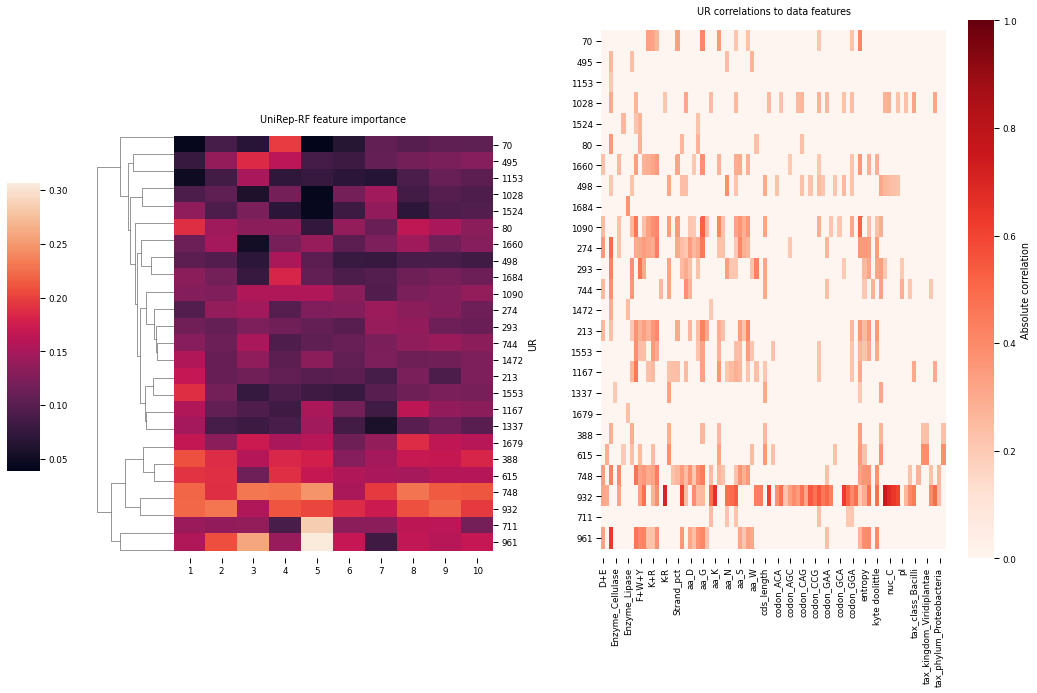

In [15]:
g = sns.clustermap(
    tops.fillna(seedimp), 
    col_cluster=False,
    figsize=(15,8),
)
g.gs.update(left=0.08, right=0.45, )
g.cax.set_position([0, .2, .03, .5]) # (left, bottom, width, height)

b, t = g.ax_heatmap.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
g.ax_heatmap.set_ylim(b, t) # update the ylim(bottom, top) values
g.ax_heatmap.set_title('UniRep-RF feature importance')

gs2 = GridSpec(1, 1, left=0.55)
ax2 = g.fig.add_subplot(gs2[0])

ylabel_order = [x.get_text() for x in g.ax_heatmap.yaxis.get_ticklabels()]
ur_df_t = ur_df.loc[:, ylabel_order].T.abs()
sns.heatmap(
    ur_df_t.fillna(0),
    ax=ax2,
    vmin=0, vmax=1,
    cmap='Reds',
     cbar_kws={'label': 'Absolute correlation'}
)
b, t = ax2.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top<
ax2.set_ylim(b, t) # update the ylim(bottom, top) values
ax2.set_title('UR correlations to data features')
ax2.set_xlabel('')


plt.tight_layout()
plt.savefig(output_dir + 'seed_imps_heatmap.pdf', bbox_inches='tight')
plt.show()

/Users/hanmar/Documents/repos/thesis_paper/env/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


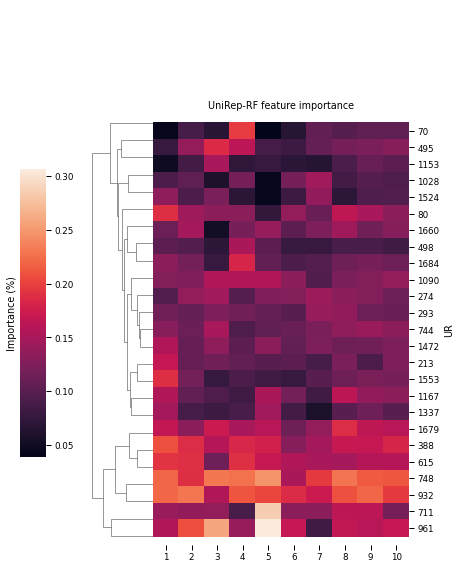

In [16]:
g = sns.clustermap(
    tops.fillna(seedimp), 
    col_cluster=False,
    figsize=(12,8),
    #cbar_kws={'label': 'Absolute correlation'}
)
g.gs.update(left=0.08, right=0.45, )
g.cax.set_position([0, .2, .03, .5]) # (left, bottom, width, height)
g.cax.set_ylabel('Importance (%)')
g.cax.yaxis.set_label_coords(-.5,0.5)

b, t = g.ax_heatmap.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
g.ax_heatmap.set_ylim(b, t) # update the ylim(bottom, top) values
g.ax_heatmap.set_title('UniRep-RF feature importance')

g.fig.tight_layout()

plt.savefig(output_dir + 'seed_imps_heatmap_left.pdf', bbox_inches='tight')

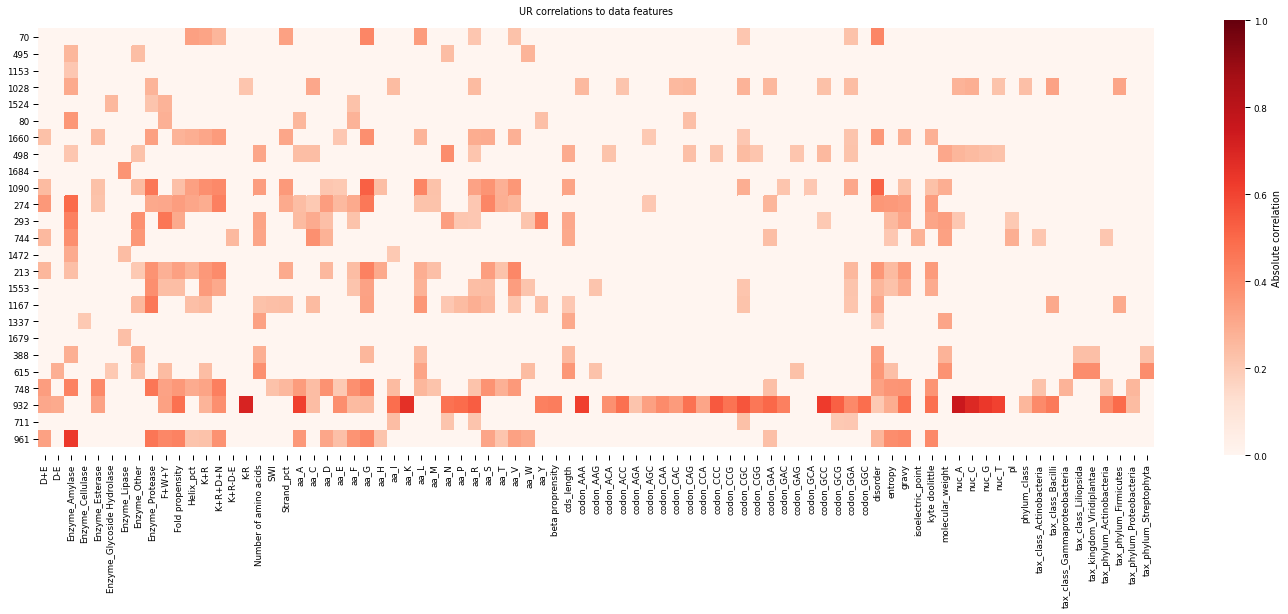

In [17]:
fig, ax2 = plt.subplots(1,1, figsize=(25, 8))
sns.heatmap(
    ur_df_t.fillna(0),
    ax=ax2,
    vmin=0, vmax=1,
    cmap='Reds',
     cbar_kws={'label': 'Absolute correlation'}
)
b, t = ax2.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top<
ax2.set_ylim(b, t) # update the ylim(bottom, top) values
ax2.set_title('UR correlations to data features')
ax2.set_xlabel('')
plt.savefig(output_dir + 'seed_imps_heatmap_right.pdf', bbox_inches='tight')

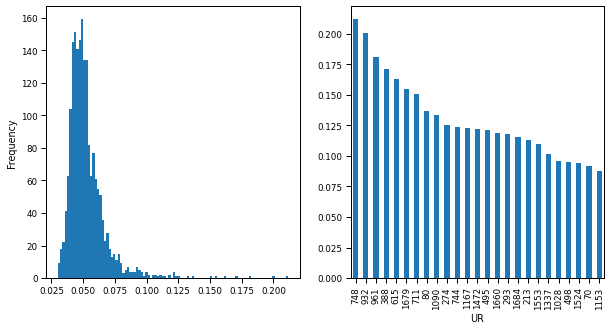

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
seedimp.mean(1).plot.hist(bins=100, ax=axes[0])
seedimp.loc[[int(x) for x in ylabel_order]].mean(1).sort_values(ascending=False).plot.bar(ax=axes[1])
plt.savefig(output_dir + 'seed_imp_avg_imps_hist.pdf')

In [19]:
def load_json(f):
    with open(f, 'r') as source:
        d = json.load(source)
    return d

node_classes=load_json('../data/node_classes.json')
node2color=load_json('../data/node2color.json')

In [24]:
from src.visualizations import corr_pval, interpret_corr, circos_cmap2legend, create_circos, prepare_circos_data

avg_seedimps = pd.DataFrame(seedimp.loc[[int(x) for x in ylabel_order]].mean(1), columns=['importance (%)'])
top=avg_seedimps.shape[0]
urs, node_classes2 = prepare_circos_data(
    corrs, avg_seedimps, node_classes, 
    interpret_col='corr', 
    groupby_col='y', 
    filter_top_units=top,
    top_ns=[1, 3]
)
urs_abs, node_classes2_abs = prepare_circos_data(
    corrs, avg_seedimps, node_classes, 
    interpret_col='abs_corr', 
    groupby_col='y', 
    filter_top_units=top,
    top_ns=[1, 3, 5, 10, 20, 30, 50]
)

targets = zip(['corr', 'abs_corr'], [urs, urs_abs], [node_classes2, node_classes2_abs], [10, 12])
out = PdfPages(output_dir + 'corr_seed_UniRep_top{}.pdf'.format(top))
for col, data, node_classes_c, legend_length in targets:
    for k, v in data.items():
        fig = create_circos(
            v,
            source='x',
            target='y',
            edge_attr=[col, 'size', 'interpretation', 'inter2', 'edge_color', 'corr_size'], 
            node_classes=node_classes_c,
            node_grouping='class',
            node_color='class',
            edge_width='corr_size',
            edge_color='interpretation',
            figsize=(20,20),
            title='Important UniRep units and their correlations',
            legend_label='inter2',
            legend_color='edge_color',
            node2color=node2color,
            legend_sort='interpretation',
            legend_length=legend_length
        )
        
        out.savefig(fig)
        plt.close(fig)
out.close()